In [164]:
# install dependencies

# !pip install numpy==1.19.5
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install numba
# !pip install joblib
# !pip install ipywidgets
# !pip install scikit-learn
# !conda install -y -c conda-forge pyts

In [165]:
import pandas as pd
import glob
from io import StringIO, BytesIO
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
from pyts.image import GramianAngularField
import random
import os
from ipywidgets import IntProgress
from IPython.display import display
import math

sns.set()

# Read in Data of a single file

In [166]:
files = glob.glob('data/*/Rides/20*/*/VM2_*')
len(files)

2320

In [167]:
def create_dfs(ride_object):
  lines = []

  with open(ride_object['file'], 'r') as f:
    lines = f.readlines()[1:] # drop first row

  # find line that starts with =========
  splitLine = -1
  for line in lines:
    if line.startswith('========='):
      splitLine = lines.index(line)
      break

  incidents = lines[0:splitLine - 1]
  ride = lines[splitLine + 2:] # there is again a version number below =========

  ride_object['df_incidents'] = pd.read_csv(StringIO(''.join(incidents)), delimiter=',')
  df_r = pd.read_csv(StringIO(''.join(ride)), delimiter=',')
  df_r.dropna(subset = ['acc'], inplace=True) # only keep columns with acc
  df_r.reset_index(inplace=True, drop=True)
  # create a new column that combines accelerometer values
  XYZ = (df_r['X'].abs() + df_r['Y'].abs() + df_r['Z'].abs()) / 3
  df_r['XYZ'] = XYZ

  ride_object['df_ride'] = df_r

ride_object = {
  'file': files[1]
}

print('Reading in ' + ride_object['file'])
create_dfs(ride_object)

ride_object['df_incidents']

Reading in data/Berlin/Rides/2020/05/VM2_1921845460


,key,lat,lon,ts,bike,childCheckBox,trailerCheckBox,pLoc,incident,i1,...,i3,i4,i5,i6,i7,i8,i9,scary,desc,i10
0,1,52.487288,13.420933,1589368537517,2,0,0,0,7,0,...,0,0,0,0,1,0,0,0,NaN,0


In [168]:
ride_object['df_ride'].shape[0]

56

In [169]:
def check_ride_valid(ride_object):
  df_r = ride_object['df_ride']
  df_i = ride_object['df_incidents']

  # check whether at least one incident
  if df_i.shape[0] == 0:
    return False

  for timestamp in df_i['ts'].tolist():
    inc_idx = df_i[df_i['ts'] == timestamp].index

    # check whether timestamp is nan (then this is not a real incident)
    if timestamp == 0 or math.isnan(timestamp):
      df_i.drop(inc_idx, inplace=True)
      continue

    ride_idx = df_r[df_r['timeStamp'] == timestamp].index

    # check if incident is in rides dataframe based on timeStamp (only once!)
    if (len(ride_idx) != 1):
      df_i.drop(inc_idx, inplace=True)
      continue

    # check whether timestamp is not at the start of the ride
    if (ride_idx[0] < 20):
      df_i.drop(inc_idx, inplace=True)
      continue

  # check whether still at least one incident
  if df_i.shape[0] == 0:
    return False

  return True

check_ride_valid(ride_object)

True

In [170]:
def calculate_ride_indices_with_incidents(ride_object):
  df_i = ride_object['df_incidents']
  df_r = ride_object['df_ride']

  indices = []
  for timestamp in df_i['ts'].tolist():
    indices.append(df_r[df_r['timeStamp'] == timestamp].index[0])
  
  ride_object['ride_indices_with_incidents'] = indices

calculate_ride_indices_with_incidents(ride_object)
ride_object['ride_indices_with_incidents']

[44]

In [171]:
def create_and_label_windows(ride_object, timeseries_length):
  df_r = ride_object['df_ride']

  ts_windows = []
  ts_hasIndicents = []

  for i, window in enumerate(df_r[['timeStamp', 'XYZ']].rolling(window=timeseries_length)):
    if i < timeseries_length:
      continue # we only want full windows, the first timeseries_lenght windows are missing values

    hasIndicent = False

    # check if any of the window's indices is in ride_indices_with_incidents
    for ri_inc in ride_object['ride_indices_with_incidents']:
      min_i = window.index.min()
      max_i = window.index.max()

      if min_i <= ri_inc <= max_i:
        hasIndicent = True
      
    ts_windows.append(np.array(window['XYZ']))
    ts_hasIndicents.append(hasIndicent)

  ride_object['ts_windows'] = ts_windows
  ride_object['ts_hasIncidents'] = ts_hasIndicents
    
create_and_label_windows(ride_object, 10)
# print number of windows with incidents
len(list(filter(lambda x: x, ride_object['ts_hasIncidents'])))

10

In [172]:
# print number of windows without incidents
len(list(filter(lambda x: not x, ride_object['ts_hasIncidents'])))

36

In [173]:
def apply_mask(data, selectors, take_0=False):
    if take_0:
      return list((d for d, s in zip(data, selectors) if not s))
    else:
      return list((d for d, s in zip(data, selectors) if s))

len(apply_mask(ride_object['ts_windows'], ride_object['ts_hasIncidents'], True))

36

<AxesSubplot:>

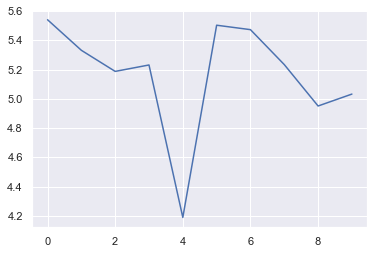

In [174]:
# plot a window
sns.lineplot(data=ride_object['ts_windows'][10])

# Write train and test data to file, select same amount of train and test

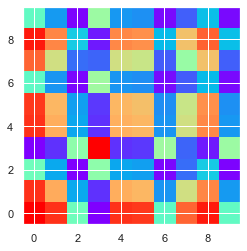

In [175]:
def create_gasf(ride_object):
  ts_w = ride_object['ts_windows']
  ts_hI = ride_object['ts_hasIncidents']

  ts_has_incident = apply_mask(ts_w, ts_hI)
  ts_no_incident = apply_mask(ts_w, ts_hI, True)

  # we only want as many no_incident as has_incident
  ts_no_incident = random.sample(ts_no_incident, len(ts_has_incident))

  # numpy
  np_hI = np.array(ts_has_incident)
  np_nI = np.array(ts_no_incident)

  # create gasf
  gasf = GramianAngularField(method='summation')
  ride_object['gasf_hasIncident'] = gasf.fit_transform(np_hI)
  ride_object['gasf_noIncident'] = gasf.fit_transform(np_nI)

create_gasf(ride_object)
plt.imshow(ride_object['gasf_hasIncident'][0], cmap='rainbow', origin='lower')

In [176]:
def store_image(gasf_result, output_path):
  buffer = BytesIO()

  plt.figure()
  plt.imshow(gasf_result, cmap='rainbow', origin='lower')
  plt.axis('off')

  plt.savefig(buffer, bbox_inches='tight')
  plt.close()

  buffer.seek(0)
  os.makedirs(os.path.dirname(output_path), exist_ok=True)
  Image.open(buffer).save(output_path)

def create_images(ride_object):
  for i, im in enumerate(ride_object['gasf_hasIncident']): 
    path = 'images/' + ride_object['file'].replace('data', '') + '*' + str(i) + '*true*' + '.png'
    store_image(im, path)

  for i, im in enumerate(ride_object['gasf_noIncident']): 
    path = 'images/' + ride_object['file'].replace('data', '') + '*' + str(i) + '*false*' + '.png'
    store_image(im, path)

create_images(ride_object)

In [177]:
tmp_files = files

f = IntProgress(min=0, max=len(tmp_files)) # instantiate the bar
display(f) # display the bar

discarded = 0
for i, file in enumerate(tmp_files):
    f.value += 1 # signal to increment the progress bar

    ride_object = {
        'file': file
    }

    create_dfs(ride_object)
    if not check_ride_valid(ride_object):
        discarded+=1
        continue
    calculate_ride_indices_with_incidents(ride_object)
    create_and_label_windows(ride_object, 10)
    create_gasf(ride_object)
    create_images(ride_object)

print('Discarded {0!s}/{1!s} rides'.format(discarded, len(tmp_files)))

IntProgress(value=0, max=2320)

Discarded 2133/2320 rides


In [178]:
i

2319